In [12]:
#!pip install --upgrade pandas plotly
#!pip install umap-learn
#!pip install pandas numpy fcsparser scikit-learn
#!pip install tensorflow keras
#!pip install matplotlib seaborn plotly
#!pip install pandas
#!pip install jupyterlab --upgrade
#!pip install -U kaleido
#jupyter labextension update jupyterlab-plotly


#!pip install umap-learn

     ---------------------------------------- 0.0/90.9 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/90.9 kB ? eta -:--:--
     ------------ ------------------------- 30.7/90.9 kB 435.7 kB/s eta 0:00:01
     ---------------------------------- --- 81.9/90.9 kB 762.6 kB/s eta 0:00:01
     -------------------------------------- 90.9/90.9 kB 739.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/55.8 kB ? eta -:--:--
   ---------------------------------------- 55.8/55.8 kB 2.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86926 sha256=f95b781b99eb4d9887dfd01a21a435a8cbeb7aa5524c8b797d683069ad942612
  Stored in directory: c:\users\herme\appdata\local\pip\cache\wheels\de\07\2e\814a6ee82e37528f2044a609a431028375b149bc31f03c0e27
Successfully built umap-learn


# Import Libraries

In [137]:
#General Imports
import os
import pandas as pd
import numpy as np
import fcsparser
from collections import Counter

#Imports for MLP
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from keras.models import load_model
from keras.layers import Dense, SimpleRNN
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense, Input 

from sklearn.mixture import GaussianMixture
import umap
from scipy.spatial.distance import cdist
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

#Visualizations

import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
import seaborn as sns
import matplotlib.pyplot as plt

#from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

#from umap import UMAP



# Import Monoculture Files and Blanks

In [225]:
def load_and_sample_data(folder_path, species, sample_size=50000, files_to_process=None):
    columns_to_keep = [ 'FSC-H','FSC-A','SSC-H','SSC-A','FITC-H', 'FITC-A','PerCP-H','PerCP-A','APC-H','APC-A','KO525-H','KO525-A','PE-H','PE-A','ECD-H','ECD-A','PI-H','PI-A','FSC-Width'] #['FSC-H', 'FSC-A', 'SSC-H', 'SSC-A', 'FITC-H', 'FITC-A', 'PI-H', 'PI-A', 'FSC-Width']
    data_list = []
    processed_files = 0
    total_samples = 0  

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.fcs'):
            if files_to_process is not None and processed_files >= files_to_process:
                break
            filepath = os.path.join(folder_path, filename)
            meta, data = fcsparser.parse(filepath, meta_data_only=False, reformat_meta=True)
            data = data.loc[:, data.columns.intersection(columns_to_keep)]
            sampled_data = data.sample(n=min(sample_size, len(data)), random_state=1)
            sampled_data['label'] = species
            data_list.append(sampled_data)
            processed_files += 1
            total_samples += len(sampled_data)  
    combined_data = pd.concat(data_list)
    return combined_data, processed_files, total_samples

# File paths and number of fsc files to import
bacteroides_data, bacteroides_files, bacteroides_samples = load_and_sample_data("C:/Users/herme/Desktop/Live_Dead_Data/BT", 'bacteroides', files_to_process=None)
blautia_data, blautia_files, blautia_samples = load_and_sample_data('C:/Users/herme/Desktop/Live_Dead_Data/BH', 'blautia', files_to_process=None)
blanks_data, blanks_files, blanks_samples = load_and_sample_data('C:/Users/herme/Desktop/Live_Dead_Data/Blanks', 'background', files_to_process=2)

#all_data = pd.concat([bacteroides_data, blautia_data, blanks_data])


In [226]:
# Display the counts for the imported files
print(f"Bacteroides: {bacteroides_files} files processed, {bacteroides_samples} samples")
print(f"Blautia: {blautia_files} files processed, {blautia_samples} samples")
print(f"Blanks: {blanks_files} files processed, {blanks_samples} samples")
total_files = bacteroides_files + blautia_files + blanks_files
total_samples = bacteroides_samples + blautia_samples + blanks_samples
print(f"Total: {total_files} files processed, {total_samples} samples")

#label_counts = all_data['label'].value_counts()
#print(label_counts)

Bacteroides: 16 files processed, 756858 samples
Blautia: 16 files processed, 800000 samples
Blanks: 2 files processed, 2003 samples
Total: 34 files processed, 1558861 samples


In [19]:
#blanks_data.to_csv('blanks_data.tsv', sep='\t', index=False)

## Distributions of Monocultures and Blanks

#### Dot plot for blautia,bacteroides and blanks (FSC vs SSC )

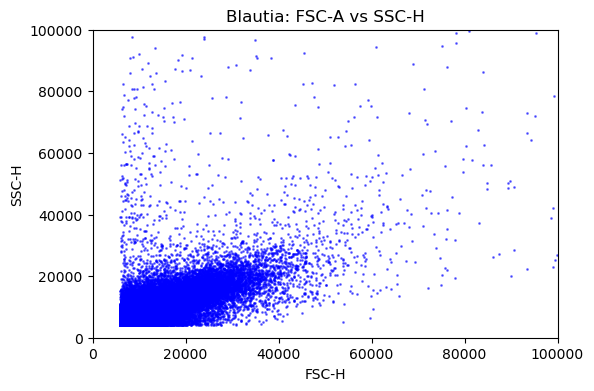

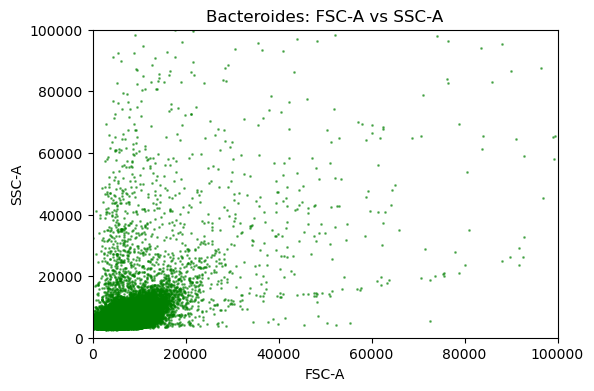

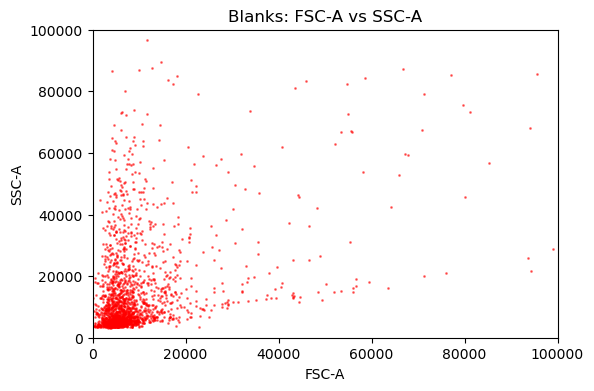

In [41]:
# axis limits 
x_min, x_max = 0, 100000  #  limits for FSC-A
y_min, y_max = 0, 100000  # limits for SSC-A

# Plot for Blautia 
plt.figure(figsize=(6, 4))
plt.scatter(blautia_data['FSC-H'], blautia_data['SSC-H'], alpha=0.5, color='blue', s=1)
plt.title('Blautia: FSC-A vs SSC-H')
plt.xlabel('FSC-H')
plt.ylabel('SSC-H')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

# Plot for Bacteroides 
plt.figure(figsize=(6, 4))
plt.scatter(bacteroides_data['FSC-A'], bacteroides_data['SSC-A'], alpha=0.5, color='green', s=1)
plt.title('Bacteroides: FSC-A vs SSC-A')
plt.xlabel('FSC-A')
plt.ylabel('SSC-A')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

# Plot for Blanks 
plt.figure(figsize=(6, 4))
plt.scatter(blanks_data['FSC-A'], blanks_data['SSC-A'], alpha=0.5, color='red', s=1)
plt.title('Blanks: FSC-A vs SSC-A')
plt.xlabel('FSC-A')
plt.ylabel('SSC-A')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

#### Save the distribution of each with plotly

In [118]:
datasets = { 'Bacteroides': bacteroides_data, 'Blautia': blautia_data, 'Blanks': blanks_data }
features_to_visualize = ['SSC-A', 'PI-H', 'FITC-A']  # Features/channels to visualize
colors = ['skyblue', 'salmon', 'lightgreen']  # Colors

for species_name, data in datasets.items():
    fig = go.Figure()

    for i, feature in enumerate(features_to_visualize):
        transformed_feature = np.arcsinh(data[feature] / 150)  
        # Add histogram for each feature with probability density
        fig.add_trace(go.Histogram(x=transformed_feature,
                                   name=f'{feature} (arcsinh transformed)',
                                   marker_color=colors[i],
                                   opacity=0.6,
                                   histnorm='probability density'))

    # Update the layout for each species plot
    fig.update_layout(title_text=f'Distributions of Channels (arcsinh transformed) - {species_name}',
                      xaxis_title_text='Arcsinh Values',
                      yaxis_title_text='Probability Density',  
                      bargap=0.2,  
                      legend_title_text='Feature')

    # Save the plot as an HTML file
    file_name = f'{species_name}_distribution_plot.html'
    plot(fig, filename=file_name, auto_open=False)

#### Show the distributions for each data(blanks ,blautia,bacteroides ) with matplot

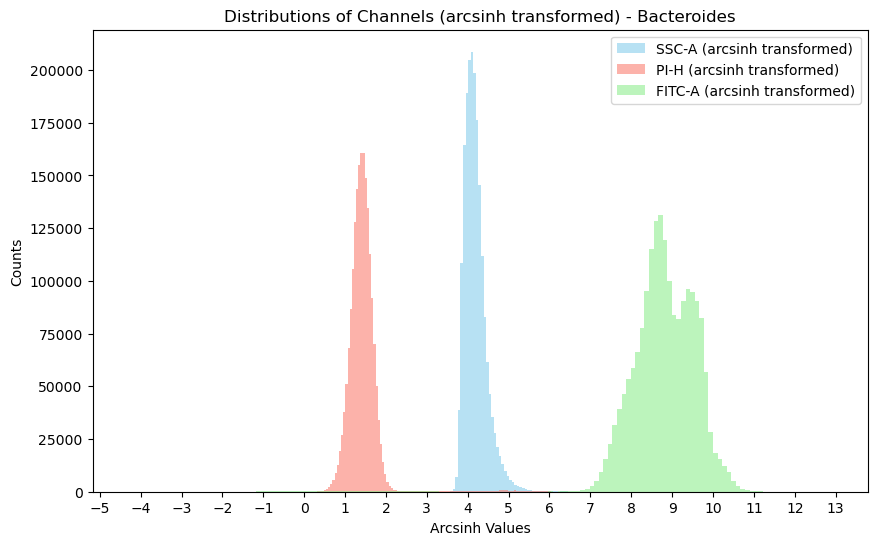

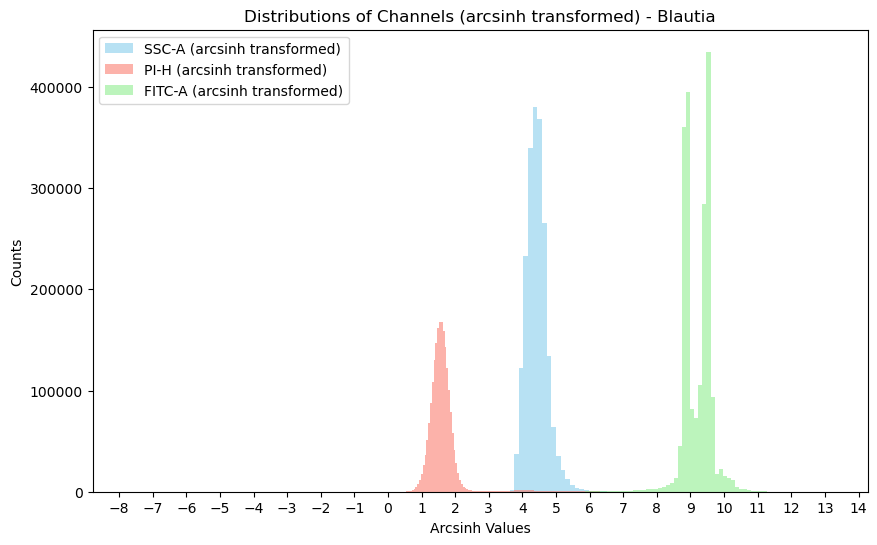

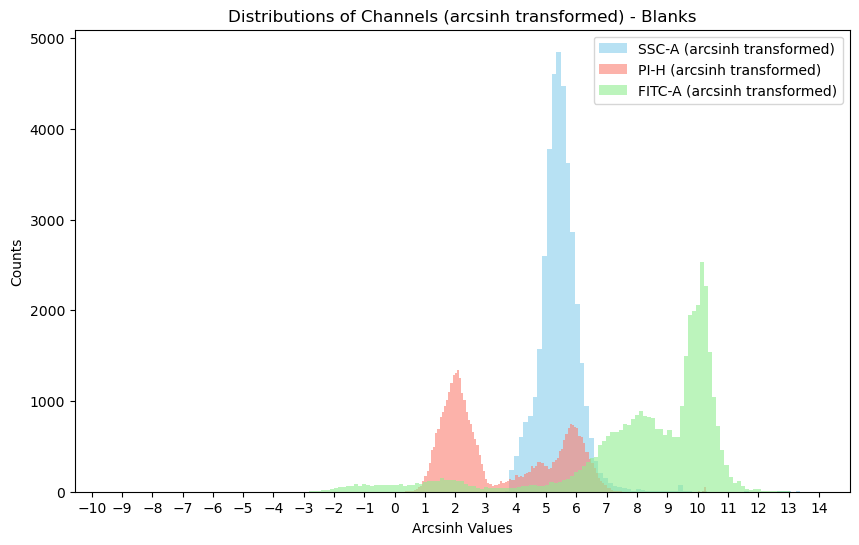

In [9]:
datasets = {
    'Bacteroides': bacteroides_data,
    'Blautia': blautia_data,
    'Blanks': blanks_data
}

features_to_visualize = ['SSC-A', 'PI-H', 'FITC-A']  # Features/channels to visualize
colors = ['skyblue', 'salmon', 'lightgreen']  # Colors for each feature

for species_name, data in datasets.items():
    plt.figure(figsize=(10, 6)) 
    
    global_min, global_max = float('inf'), float('-inf')
    
    # Plot histogram for each feature
    for i, feature in enumerate(features_to_visualize):
        transformed_feature = np.arcsinh(data[feature] / 150)
        
        feature_min, feature_max = transformed_feature.min(), transformed_feature.max()
        global_min, global_max = min(global_min, feature_min), max(global_max, feature_max)
        
        # Plotting the histogram for counts
        plt.hist(transformed_feature, bins=150, color=colors[i], alpha=0.6, density=False, label=f'{feature} (arcsinh transformed)')
    
    plt.xticks(np.arange(np.floor(global_min), np.ceil(global_max) + 1, 1))
    
    plt.title(f'Distributions of Channels (arcsinh transformed) - {species_name}')
    plt.xlabel('Arcsinh Values')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

#### Overimpose FITC-A of blanks on top of bacteroides and blautia to check

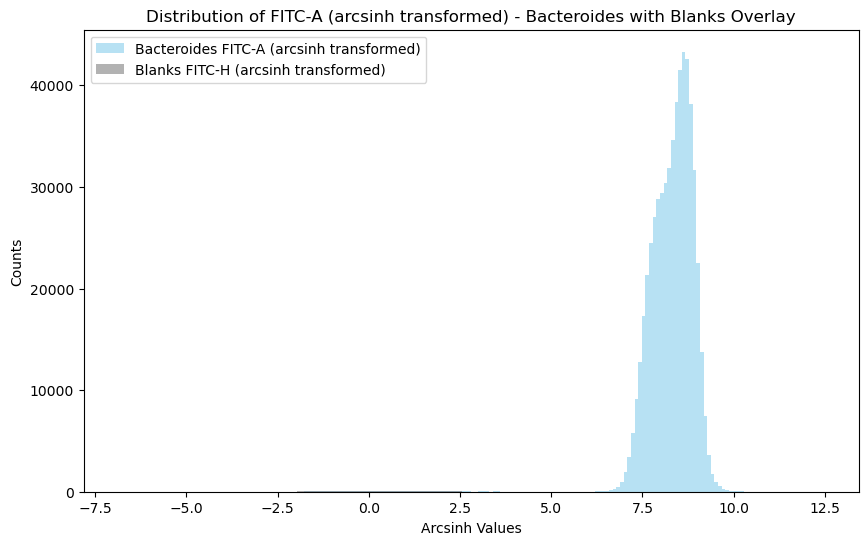

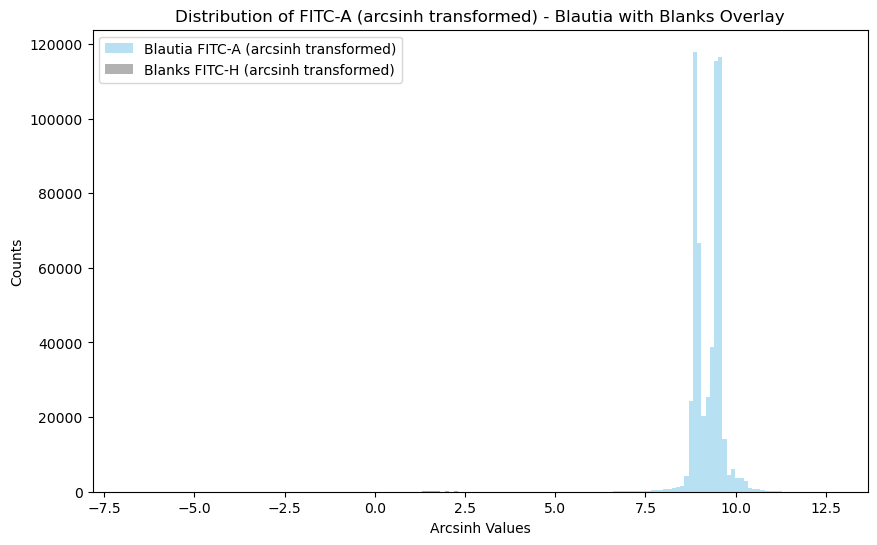

In [43]:
datasets = { 'Bacteroides': bacteroides_data, 'Blautia': blautia_data, 'Blanks': blanks_data }
feature_to_visualize = 'FITC-A'  
color = 'skyblue'  

for species_name, data in datasets.items():
    if species_name in ['Bacteroides', 'Blautia']:  #overlay on these species
        plt.figure(figsize=(10, 6)) 
        
        transformed_feature = np.arcsinh(data[feature_to_visualize] / 150)

        # Plotting the histogram 
        plt.hist(transformed_feature, bins=150, color=color, alpha=0.6, density=False, label=f'{species_name} {feature_to_visualize} (arcsinh transformed)')

        # Overlay FITC-A channel for blanks
        transformed_blanks = np.arcsinh(datasets['Blanks'][feature_to_visualize] / 150)
        plt.hist(transformed_blanks, bins=150, color='grey', alpha=0.6, density=False, label='Blanks FITC-H (arcsinh transformed)')

        plt.title(f'Distribution of {feature_to_visualize} (arcsinh transformed) - {species_name} with Blanks Overlay')
        plt.xlabel('Arcsinh Values')
        plt.ylabel('Counts')
        plt.legend()
        plt.show()

# Concatanate the 3 datasets (Blautia,bacteroides,blanks)

In [227]:
#  concatenate the three datasets
all_data = pd.concat([bacteroides_data, blautia_data, blanks_data])
#all_data = pd.concat([bacteroides_data_cluster, blautia_data_cluster,blanks_data_cluster])

In [228]:
all_data.label.value_counts()


label
blautia        800000
bacteroides    756858
background       2003
Name: count, dtype: int64

# Gating with UMAP to clean the Monocultures and blanks

In [229]:
columns_to_plot = ['FSC-H','FSC-A','SSC-H','SSC-A','FITC-H', 'FITC-A','PI-H','PI-A']
data_subset = all_data[columns_to_plot].values

# Create the pair plot
#sns.pairplot(data_subset, hue='label')

In [ ]:
# Initialize the UMAP 
reducer = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0)

scaled_data_subset  = StandardScaler().fit_transform(data_subset)

# UMAP reduction
embedding = reducer.fit_transform(scaled_data_subset)



In [185]:
print(embedding.shape)  

(322003, 3)


#### pLOTING WITH PLOTLY THE UMAPS 

In [145]:
# Map labels to integers
label_map = {"bacteroides": 0, "blautia": 1, "background": 2}
mapped_labels = all_data.label.map(label_map)

# Convert mapped label to color 
colors = pd.Series(mapped_labels).map({0: 'skyblue', 1: 'green', 2: 'red'}).values

# figure
fig = go.Figure(data=[go.Scatter3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=colors,                
        opacity=0.8
    ),
    text=all_data.label.values 
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    title={
        'text': "3D UMAP projection of the all_data dataset",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)

#fig.show()
# Save the figure
fig.write_html("Umap_comparison_all_data.html")

#### Filter the dataset to remove misslabelled points----using NN neighbour in combination with the Umap embeddings

In [186]:
# Map labels to integers
label_map = {"bacteroides": 0, "blautia": 1, "background": 2}
mapped_labels = all_data['label'].map(label_map).values

# NearestNeighbors initialization to find 11 neighbors 
nn = NearestNeighbors(n_neighbors=11)
nn.fit(embedding)

# 11 nearest neighbors for each point
distances, indices = nn.kneighbors(embedding)

#  a list to accumulate indices of points to keep
indices_to_keep = []

# Loop through each point to check against its 10 nearest neighbors
for i in range(len(embedding)):
    neighbor_labels = mapped_labels[indices[i][1:]]  
    
    # Count how many of the 10 nearest neighbors have the same label as the current point
    same_label_count = np.sum(neighbor_labels == mapped_labels[i])
    
    # Keep the point if at least 5 out of 10 neighbors have the same label
    if same_label_count >= 5:
        indices_to_keep.append(i)

#  new dataset with points that have at least 5 out of 10 nearest neighbors with the same label
cleaned_data = all_data.iloc[indices_to_keep]


In [187]:
print(cleaned_data.shape)
#cleaned_data.to_csv('cleaned_data.tsv', sep='\t', index=False)

(286351, 20)


In [188]:
cleaned_data.label.value_counts()

label
blautia        145149
bacteroides    139574
background       1628
Name: count, dtype: int64

#### Umap for the cleaned dataset

In [189]:
columns_to_plot = ['FSC-H','FSC-A','SSC-H','SSC-A','FITC-H', 'FITC-A','PI-H','PI-A']
data_subset_cleaned = cleaned_data[columns_to_plot].values

# Initialize the UMAP 
reducer = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0)

scaled_data_subset_cleaned  = StandardScaler().fit_transform(data_subset_cleaned)

# UMAP reduction
embedding_cleaned = reducer.fit_transform(scaled_data_subset_cleaned )
print(embedding_cleaned.shape)  


(286351, 3)


#### Plotly to visualize the umap of the cleaned dataset

In [190]:
# Map labels to integers
label_map_cleaned = {"bacteroides": 0, "blautia": 1, "background": 2}
mapped_labels_cleaned = cleaned_data.label.map(label_map_cleaned)

# Convert mapped label to color 
colors = pd.Series(mapped_labels_cleaned).map({0: 'skyblue', 1: 'green', 2: 'red'}).values

# figure
fig = go.Figure(data=[go.Scatter3d(
    x=embedding_cleaned[:, 0],
    y=embedding_cleaned[:, 1],
    z=embedding_cleaned[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=colors,                
        opacity=0.8
    ),
    text=cleaned_data.label.values 
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    title={
        'text': "3D UMAP projection of the cleaned_data dataset",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)

#fig.show()
# Save the figure
fig.write_html("Cleaned_data_Umap_comparison_all_data.html")

In [191]:
#all_data.to_csv('all_data.tsv', sep='\t', index=False)
#cleaned_data.to_csv('cleaned_data.tsv', sep='\t', index=False)

# Prepare the Imported Monoculture and Blank files for Training

In [195]:
# Preparing the dataset for training (all the monoculture fsc+blanks)
#all_data_copy=all_data.copy()
cleaned_data_copy=cleaned_data.copy()
#X = all_data_copy.drop('label', axis=1)
X=cleaned_data_copy.drop('label', axis=1)


# Standard scaling 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# arcsinh transformation
X_arcsinh = np.arcsinh(X_scaled / 150)

# PCA Whitening
pca = PCA(whiten=True)
X_whitened = pca.fit_transform(X_arcsinh)

# LabelEncoder and encode the labels
le = LabelEncoder()
y = le.fit_transform(cleaned_data['label'])
y_categorical = to_categorical(y)


# Splitting the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_whitened  , y_categorical, test_size=0.2, random_state=42) #X_whitened instead of arcsinh



#### Check the encoded labels used for training

In [196]:
# Check what 0, 1, and 2 correspond to in the labels for the encoding
labels_to_check = [0, 1, 2]
original_labels = le.inverse_transform(labels_to_check)

# Print the original string labels for 0, 1, and 2
print({encoded: label for encoded, label in zip(labels_to_check, original_labels)})

{0: 'background', 1: 'bacteroides', 2: 'blautia'}


In [197]:
#Check label Encoding
#print(y)
#print(y_categorical )
#y_df=pd.DataFrame(y)
#y_cat_df=pd.DataFrame(y_categorical)
#y_df.to_csv('y.tsv', sep='\t', index=False)
#y_cat_df.to_csv('y_cate.tsv', sep='\t', index=False)

# To see the mapping from integer encoding back to original string labels:
#inverse_map = le.inverse_transform(y)

# Now, 'inverse_map' is a dictionary where keys are integer labels and values are the original strings
#print(inverse_map)

# Train the Neural Network(feedfowrward)-(2 hidden layers with relu and 1 output layer with softmax for classification) 

In [198]:
# Neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # input shape 
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  #  validation accuracy
    min_delta=0.01,  # Minimum change to qualify as  improvement
    patience=10,  #  epochs to wait for improvement
    verbose=1,  # Log when training is stopped
    mode='max',  # Stop training when the quantity monitored has stopped increasing
    #restore_best_weights=True  # Restore model weights from the epoch with the best value
)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32,callbacks=[early_stopping])

# Save the trained model
model.save('trained_model.keras')  # Replace 'trained_model.keras' with your desired file path.If not trained model will be saved in the same folder as this notebook

Epoch 1/50
7159/7159 ━━━━━━━━━━━━━━━━━━━━ 6s 734us/step - accuracy: 0.9521 - loss: 0.1420 - val_accuracy: 0.9872 - val_loss: 0.0382
Epoch 2/50
7159/7159 ━━━━━━━━━━━━━━━━━━━━ 5s 694us/step - accuracy: 0.9877 - loss: 0.0397 - val_accuracy: 0.9894 - val_loss: 0.0319
Epoch 3/50
7159/7159 ━━━━━━━━━━━━━━━━━━━━ 5s 702us/step - accuracy: 0.9890 - loss: 0.0321 - val_accuracy: 0.9902 - val_loss: 0.0333
Epoch 4/50
7159/7159 ━━━━━━━━━━━━━━━━━━━━ 5s 694us/step - accuracy: 0.9900 - loss: 0.0292 - val_accuracy: 0.9916 - val_loss: 0.0264
Epoch 5/50
7159/7159 ━━━━━━━━━━━━━━━━━━━━ 5s 669us/step - accuracy: 0.9905 - loss: 0.0270 - val_accuracy: 0.9913 - val_loss: 0.0269
Epoch 6/50
7159/7159 ━━━━━━━━━━━━━━━━━━━━ 5s 697us/step - accuracy: 0.9908 - loss: 0.0263 - val_accuracy: 0.9909 - val_loss: 0.0279
Epoch 7/50
7159/7159 ━━━━━━━━━━━━━━━━━━━━ 5s 667us/step - accuracy: 0.9918 - loss: 0.0238 - val_accuracy: 0.9923 - val_loss: 0.0232
Epoch 8/50
7159/7159 ━━━━━━━━━━━━━━━━━━━━ 5s 674us/step - accuracy: 0.9915 -

## Model Statistics

In [199]:
# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Define class labels (ensure these match the order used in labelencoder)
class_labels = ['background', 'bacteroides', 'blautia']  # Adjust as per your classes

#  column widths based on the longest label
label_length = max([len(label) for label in class_labels])
column_width = max(label_length, max([len(str(x)) for x in conf_matrix.flatten()])) + 2  # Adding some padding

# Print the confusion matrix with class labels
print("\nConfusion Matrix :\n                          Predicted")

# Print header with class labels
header_row = "".join(label.center(column_width) for label in [""] + class_labels)
print(header_row)

# Print each row of the cm
for label, row in zip(class_labels, conf_matrix):
    row_str = "".join(str(x).center(column_width) for x in row)
    print(f"{label.center(column_width)}{row_str}")

1790/1790 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step

Confusion Matrix :
                          Predicted
               background  bacteroides    blautia   
  background      319           1            0      
 bacteroides       16         27540         197     
   blautia         1           223         28974    


In [200]:
# Load the trained model
#model = load_model('trained_model.keras') 

# Evaluate the loaded model
evaluation = model.evaluate(X_val, y_val)

# Print evaluation metrics
print("Evaluation Metrics:")
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


1790/1790 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - accuracy: 0.9925 - loss: 0.0225
Evaluation Metrics:
Loss: 0.022987691685557365
Accuracy: 0.9923521280288696
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       320
           1       0.99      0.99      0.99     27753
           2       0.99      0.99      0.99     29198

    accuracy                           0.99     57271
   macro avg       0.98      0.99      0.99     57271
weighted avg       0.99      0.99      0.99     57271



In [201]:
# Check what 0, 1, and 2 correspond to in the labels for the encoding:
labels_to_check = [0, 1, 2]
original_labels = le.inverse_transform(labels_to_check)

# Print the original string labels for 0, 1, and 2
print({encoded: label for encoded, label in zip(labels_to_check, original_labels)})

{0: 'background', 1: 'bacteroides', 2: 'blautia'}


In [202]:
#  predicted classes(look for the necoding, in our case 0 is bacteroides,1 is blanks and 2 is blautia)
predicted_classes_distribution = Counter(y_pred_classes)
print(predicted_classes_distribution)

Counter({2: 29171, 1: 27764, 0: 336})


# Import the Coculture cytometry file and predict the labels

In [215]:
#Function to rpedict and import ,nothing to do here
    
def predict_species(filepath, model, columns_to_keep):
    _, data = fcsparser.parse(filepath, reformat_meta=True)
    data_df = pd.DataFrame(data)[columns_to_keep]
    
    #Z-standardization
    X_co_scaled=scaler.transform(data_df)
    
    # Apply arcsinh transformation
    data_df_arcsinh = np.arcsinh(X_co_scaled / 150)
    
    # Apply PCA whitening to the dataset
    X_data_df_whitened = pca.transform(data_df_arcsinh)
      
    predictions = model.predict(X_data_df_whitened) #X_data_df_whitened
    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes,data_df


## Choose path of the Coculture and Predict

In [216]:
for class_label, encoded_label in zip(le.classes_, range(len(le.classes_))):
    print(f"{class_label}: {encoded_label}")

background: 0
bacteroides: 1
blautia: 2


In [217]:
# columns to keep
columns_to_keep = [  'FSC-H','FSC-A','SSC-H','SSC-A','FITC-H', 'FITC-A','PerCP-H','PerCP-A','APC-H','APC-A','KO525-H','KO525-A','PE-H','PE-A','ECD-H','ECD-A','PI-H','PI-A','FSC-Width']

# --------------------->> Coculture path here <<-------------------------------------
coculture_filepath = 'C:/Users/herme/Desktop/Live_Dead_Data/BHBT/06-t76_d100_wc_bhbtC-D4.fcs' #here is the path to fsc

C,data_df = predict_species(coculture_filepath, model, columns_to_keep)


# Mapping prediction indices back to species names (need to be in the order the were in label encoder)
index_to_species = {0: 'background', 1: 'bacteroides', 2: 'blautia'} 
mapped_predictions = np.vectorize(index_to_species.get)(C)

# Adding predictions to the coculture data 
#coculture_data['predictions'] = mapped_predictions
data_df['predictions'] = mapped_predictions

5659/5659 ━━━━━━━━━━━━━━━━━━━━ 3s 564us/step


## Distributions Coculture

#### Save it with plotly

In [108]:
features_to_visualize = ['SSC-A', 'PI-H', 'FITC-A']  # Features/channels to visualize
colors = ['skyblue', 'red', 'lightgreen']  # Colors for each distribution

fig = go.Figure()

for i, feature in enumerate(features_to_visualize):
    transformed_feature = np.arcsinh(data_df[feature] / 150)
    # Add histogram for each feature
    fig.add_trace(go.Histogram(x=transformed_feature,
                               name=f'{feature} (arcsinh transformed)',
                               marker_color=colors[i],
                               opacity=0.6,
                               histnorm='probability density'))

fig.update_layout(title_text='Distributions of Channels (arcsinh transformed)',
                  xaxis_title_text='Arcsinh Values',
                  yaxis_title_text='Probability Density',
                  legend_title_text='Feature')

# Save the figure
fig.write_html("Distrib_Coculture.html")

#### Show the distributions with matplot

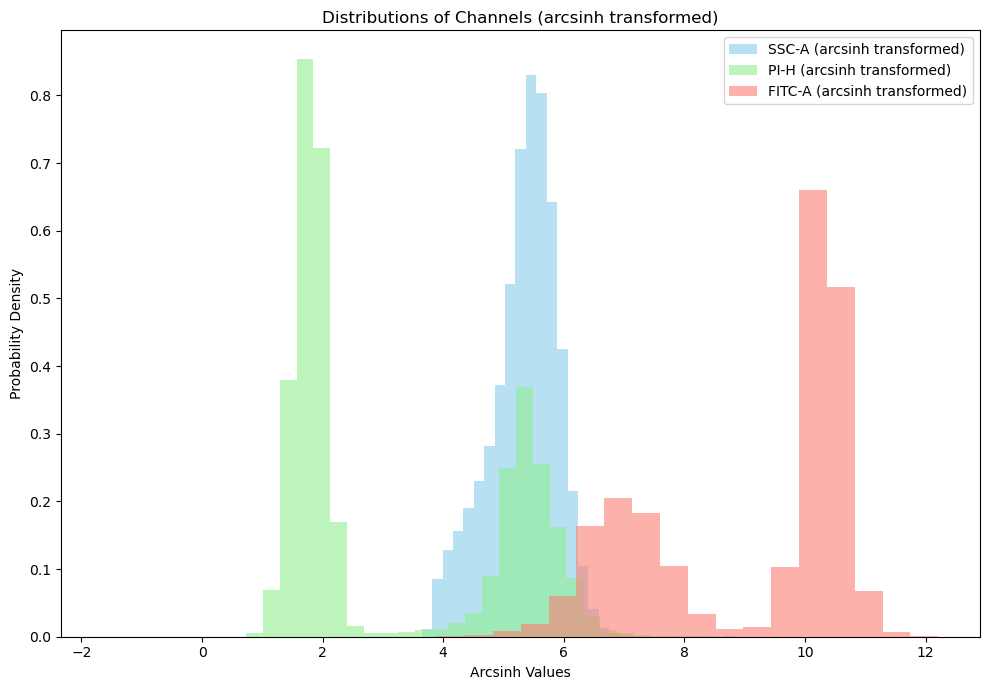

In [75]:
features_to_visualize = ['SSC-A', 'PI-H', 'FITC-A']  # Features/channels to visualize
colors = ['skyblue', 'lightgreen', 'salmon']  # Colors for each distribution

# Create a figure and axis
plt.figure(figsize=(10, 7))

# Loop through each feature to create a histogram
for i, feature in enumerate(features_to_visualize):
    # Apply arcsinh transformation
    transformed_feature = np.arcsinh(data_df[feature] / 150)
    
    # Plot histogram for each transformed feature
    plt.hist(transformed_feature, bins=30, color=colors[i], alpha=0.6, density=True, label=f'{feature} (arcsinh transformed)')

# Update the layout
plt.title('Distributions of Channels (arcsinh transformed)')
plt.xlabel('Arcsinh Values')
plt.ylabel('Probability Density')
plt.legend()  # Show the legend

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

## Count and Check Predictions from Coculture

In [218]:
# Print the last five rows of coculture
print(data_df.tail())


               FSC-H         FSC-A         SSC-H         SSC-A        FITC-H  \
181073   8889.099609   5525.600098   5013.299805   4667.399902  3.864362e+05   
181074  11623.700195  13163.299805   7732.299805   7123.799805  1.124027e+06   
181075  10616.299805   7396.200195   6288.799805   5292.399902  1.028854e+06   
181076  11174.799805   5999.700195  13096.900391  12476.400391  1.973117e+06   
181077   7301.500000   2226.800049   9016.500000   7422.200195  6.124550e+04   

              FITC-A       PerCP-H       PerCP-A       APC-H      APC-A  \
181073  3.386300e+05  7.016730e+04  7.069770e+04  208.800003 -25.900000   
181074  1.024938e+06  2.204312e+05  1.993390e+05  229.000000  -3.400000   
181075  9.145331e+05  2.169689e+05  1.954350e+05  132.199997  12.600000   
181076  1.991045e+06  3.900460e+05  3.995594e+05  222.800003  57.299999   
181077  5.292410e+04  2.715922e+06  2.402731e+06  229.500000  12.100000   

            KO525-H      KO525-A         PE-H         PE-A         E

In [219]:
#----------------->> Prediction Counts <<-----------------------------
prediction_counts = data_df['predictions'].value_counts()
print("Prediction Counts:")
print(prediction_counts)

Prediction Counts:
predictions
bacteroides    123086
blautia         57715
background        277
Name: count, dtype: int64


# Visualization

In [220]:
#  arcsinh transformation to numeric columns
coculture_data_numeric = data_df[[   'FSC-H','FSC-A','SSC-H','SSC-A','FITC-H', 'FITC-A','PerCP-H','PerCP-A','APC-H','APC-A','KO525-H','KO525-A','PE-H','PE-A','ECD-H','ECD-A','PI-H','PI-A','FSC-Width']]
coculture_data_arcsin = np.arcsinh(coculture_data_numeric / 150)

# Reintegrate 'predictions' column from original data
coculture_data_arcsin['predictions'] = data_df['predictions']

# colors for each prediction label
color_map = {
    'bacteroides': 'skyblue',  #  color for bacteroides
    'blautia': 'lime',       #  color for blautia
    'background': 'gray'        # color for blank
}

# Create the 3D scatter plot 
fig = px.scatter_3d(coculture_data_arcsin, x='SSC-A', y='FITC-A', z='PI-A', 
                    color='predictions',  
                    color_discrete_map=color_map,  
                    title="Coculture Predictions", 
                    labels={'SSC-A': 'SSC-A', 
                            'FITC-A': 'FITC-A Fluorescence', 
                            'PI-H': 'PI-A Fluorescence', 
                            'predictions': 'Predictions'})

# Adjust the layout
fig.update_layout(width=1000, height=800)
fig.update_traces(marker=dict(size=1.1))  

# Adjusting the legend size
fig.update_layout(
    legend=dict(
        title_font_size=20,  
        font=dict(
            size=17,  
        ),
    )
)

#fig.show()
fig.write_html('3D_coculture_predictions.html')

# Gating

In [221]:
def apply_gating(data_df, pi_threshold, sybr_threshold):
    # Copy the DataFrame to not change the original data 
    gated_data_df = data_df.copy()
    
    # arcsinh transformation with a cofactor
    cofactor = 150  # Cofactor 

    # arcsinh transformation to numerical columns only
    for column in gated_data_df.select_dtypes(include=[np.number]).columns:
        gated_data_df[column] = np.arcsinh(gated_data_df[column] / cofactor)
    
    # Initialize the 'state' column with 'live' assuming most cells are live
    gated_data_df['state'] = 'live'
    
    # Identify inactive cells based on PI threshold
    gated_data_df.loc[gated_data_df['PI-A'] > pi_threshold, 'state'] = 'inactive'
    
    # Identify debris based on SYBR green (FITC-A) threshold among the remaining 'live' cells
    gated_data_df.loc[(gated_data_df['state'] == 'live') & (gated_data_df['FITC-A'] < sybr_threshold), 'state'] = 'debris'
    
    return gated_data_df

# Define your PI and SYBR green thresholds
pi_threshold = 2                  #-------->> Define your PI threshold value here <<------------
sybr_threshold = 7                # -------->> Define your SYBR green threshold value here <<---------------

# Apply gating to the data
gated_data_df = apply_gating(data_df, pi_threshold, sybr_threshold)

In [222]:
#print(gated_data_df)

### Counts after gating coculture and predictions

In [223]:
# Prediction Counts
state_counts = gated_data_df['state'].value_counts()
print("State Counts:")
print(state_counts)

State Counts:
state
live        159096
inactive     21727
debris         255
Name: count, dtype: int64


In [212]:
# Filter for each condition
bacteroides_counts = gated_data_df[gated_data_df['predictions'] == 'bacteroides']['state'].value_counts()
blautia_counts = gated_data_df[gated_data_df['predictions'] == 'blautia']['state'].value_counts()
blanks_counts = gated_data_df[gated_data_df['predictions'] == 'background']['state'].value_counts()

# Print 
print("Bacteroides State Counts:")
print(bacteroides_counts)
print("\nBlautia State Counts:")
print(blautia_counts)
print("\nBackground State Counts:")
print(blanks_counts)


Bacteroides State Counts:
state
live        74142
inactive     5404
debris         27
Name: count, dtype: int64

Blautia State Counts:
state
inactive    23777
live        17956
Name: count, dtype: int64

Background State Counts:
state
debris      267
inactive     29
Name: count, dtype: int64


###  3D plot with the gating classifications

In [224]:
fig = go.Figure()

#  unique states and predictions for color
states = gated_data_df['state'].unique()
predictions = gated_data_df['predictions'].unique()

# Color map 
state_colors = {'live': 'skyblue', 'inactive': 'firebrick', 'debris': 'darkslategrey'}
prediction_markers = {'bacteroides': 'circle', 'background': 'square', 'blautia': 'diamond'}

# Plot each combination of state and prediction
for state in states:
    for prediction in predictions:
        df_filtered = gated_data_df[(gated_data_df['state'] == state) & (gated_data_df['predictions'] == prediction)]
        fig.add_trace(go.Scatter3d(
            x=df_filtered['SSC-A'],
            y=df_filtered['FITC-A'],
            z=df_filtered['PI-H'],
            mode='markers',
            marker=dict(
                size=1,
                symbol=prediction_markers[prediction],  #  markers for predictions
                color=state_colors[state],  #  color state
            ),
            name=f'{state} - {prediction}'
        ))

# layout 
fig.update_layout(
    title="3D Scatter Plot of Gated Data by State and Prediction",
    scene=dict(
        xaxis_title='SSC-A',
        yaxis_title='FITC-A',
        zaxis_title='PI-H'
    )
)
fig.update_layout(width=1000, height=800)

# Adjusting the legend size
fig.update_layout(
    legend=dict(
        title_font_size=20,  
        font=dict(
            size=17,  
        ),
    )
)

fig.write_html('3D_Gating_predictions_coculture.html')
#fig.show()